<a href="https://colab.research.google.com/github/Idank96/Deep-Learning-Projects/blob/main/Optimized_Inference_With_TensorRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare model inference runtimes between:
### 1. CPU
### 2. GPU with CUDA
### 3. TensorRT on GPU

In [1]:
!pip install pandas
!sudo apt-get install tensorrt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cuda-cccl-12-1 cuda-cccl-12-2 cuda-cudart-12-1 cuda-cudart-12-2
  cuda-cudart-dev-12-1 cuda-cudart-dev-12-2 cuda-driver-dev-12-1
  cuda-driver-dev-12-2 cuda-nvcc-12-1 cuda-toolkit-12-1-config-common
  cuda-toolkit-12-2-config-common cuda-toolkit-12-config-common libcublas-12-2
  libcublas-dev-12-2 libnvinfer-bin libnvinfer-dev libnvinfer-dispatch-dev
  libnvinfer-dispatch8 libnvinfer-headers-dev libnvinfer-headers-plugin-dev
  libnvinfer-lean-dev libnvinfer-lean8 libnvinfer-plugin-dev
  libnvinfer-plugin8 libnvinfer-samples libnvinfer-vc-plugin-dev
  libnvinfer-vc-plugin8 libnvinfer8 libnvonnxparsers-dev libnvonnxparsers8
  libnvparsers-dev libnvparsers8
The following NEW packages will be installed:
  cuda-cccl-12-1 cuda-cccl-12-2 cuda-cudart-12-1 cuda-cudart-12-2
  cuda-cudart-dev-12-1 cuda-cudart-dev-12-2 cuda-driver-dev-12-1
  cuda-d

In [2]:
from torchvision import models, transforms
import pandas as pd
import numpy as np
import torch
import time

# General System Details

In [4]:
import torch.cuda as cuda

# GPU Details
if cuda.is_available():
    device = torch.cuda.current_device()
    print(f'GPU Access: {torch.cuda.is_available()}')
    print(f"GPU Device Name: {cuda.get_device_name(device)}")
    print(f"GPU Device Capability: {cuda.get_device_capability(device)}")
    print(f"GPU Total Memory: {cuda.get_device_properties(device).total_memory / 1e9} GB")
else:
    print("No GPU available.")

# General information about the CUDA memory
print(torch.cuda.memory_summary(device=None, abbreviated=False))

# CUDA Details
print(f"CUDA Version: {torch.version.cuda}")
print(f"CUDNN Version: {torch.backends.cudnn.version()}")

# System Information
import platform
print(f"System: {platform.system()} {platform.release()}")
print(f"Processor: {platform.processor()}")

print(f'CUDA Version: {torch.version.cuda}')
print(f'PyTorch Version: {torch.__version__}')

GPU Access: True
GPU Device Name: Tesla V100-SXM2-16GB
GPU Device Capability: (7, 0)
GPU Total Memory: 16.935419904 GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory        

In [22]:
# Using CPU
# model = models.resnet50(pretrained=True)

# Using GPU
model = models.resnet50(pretrained=True).to("cuda")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Retrieve the inference image

Mounted at /content/drive


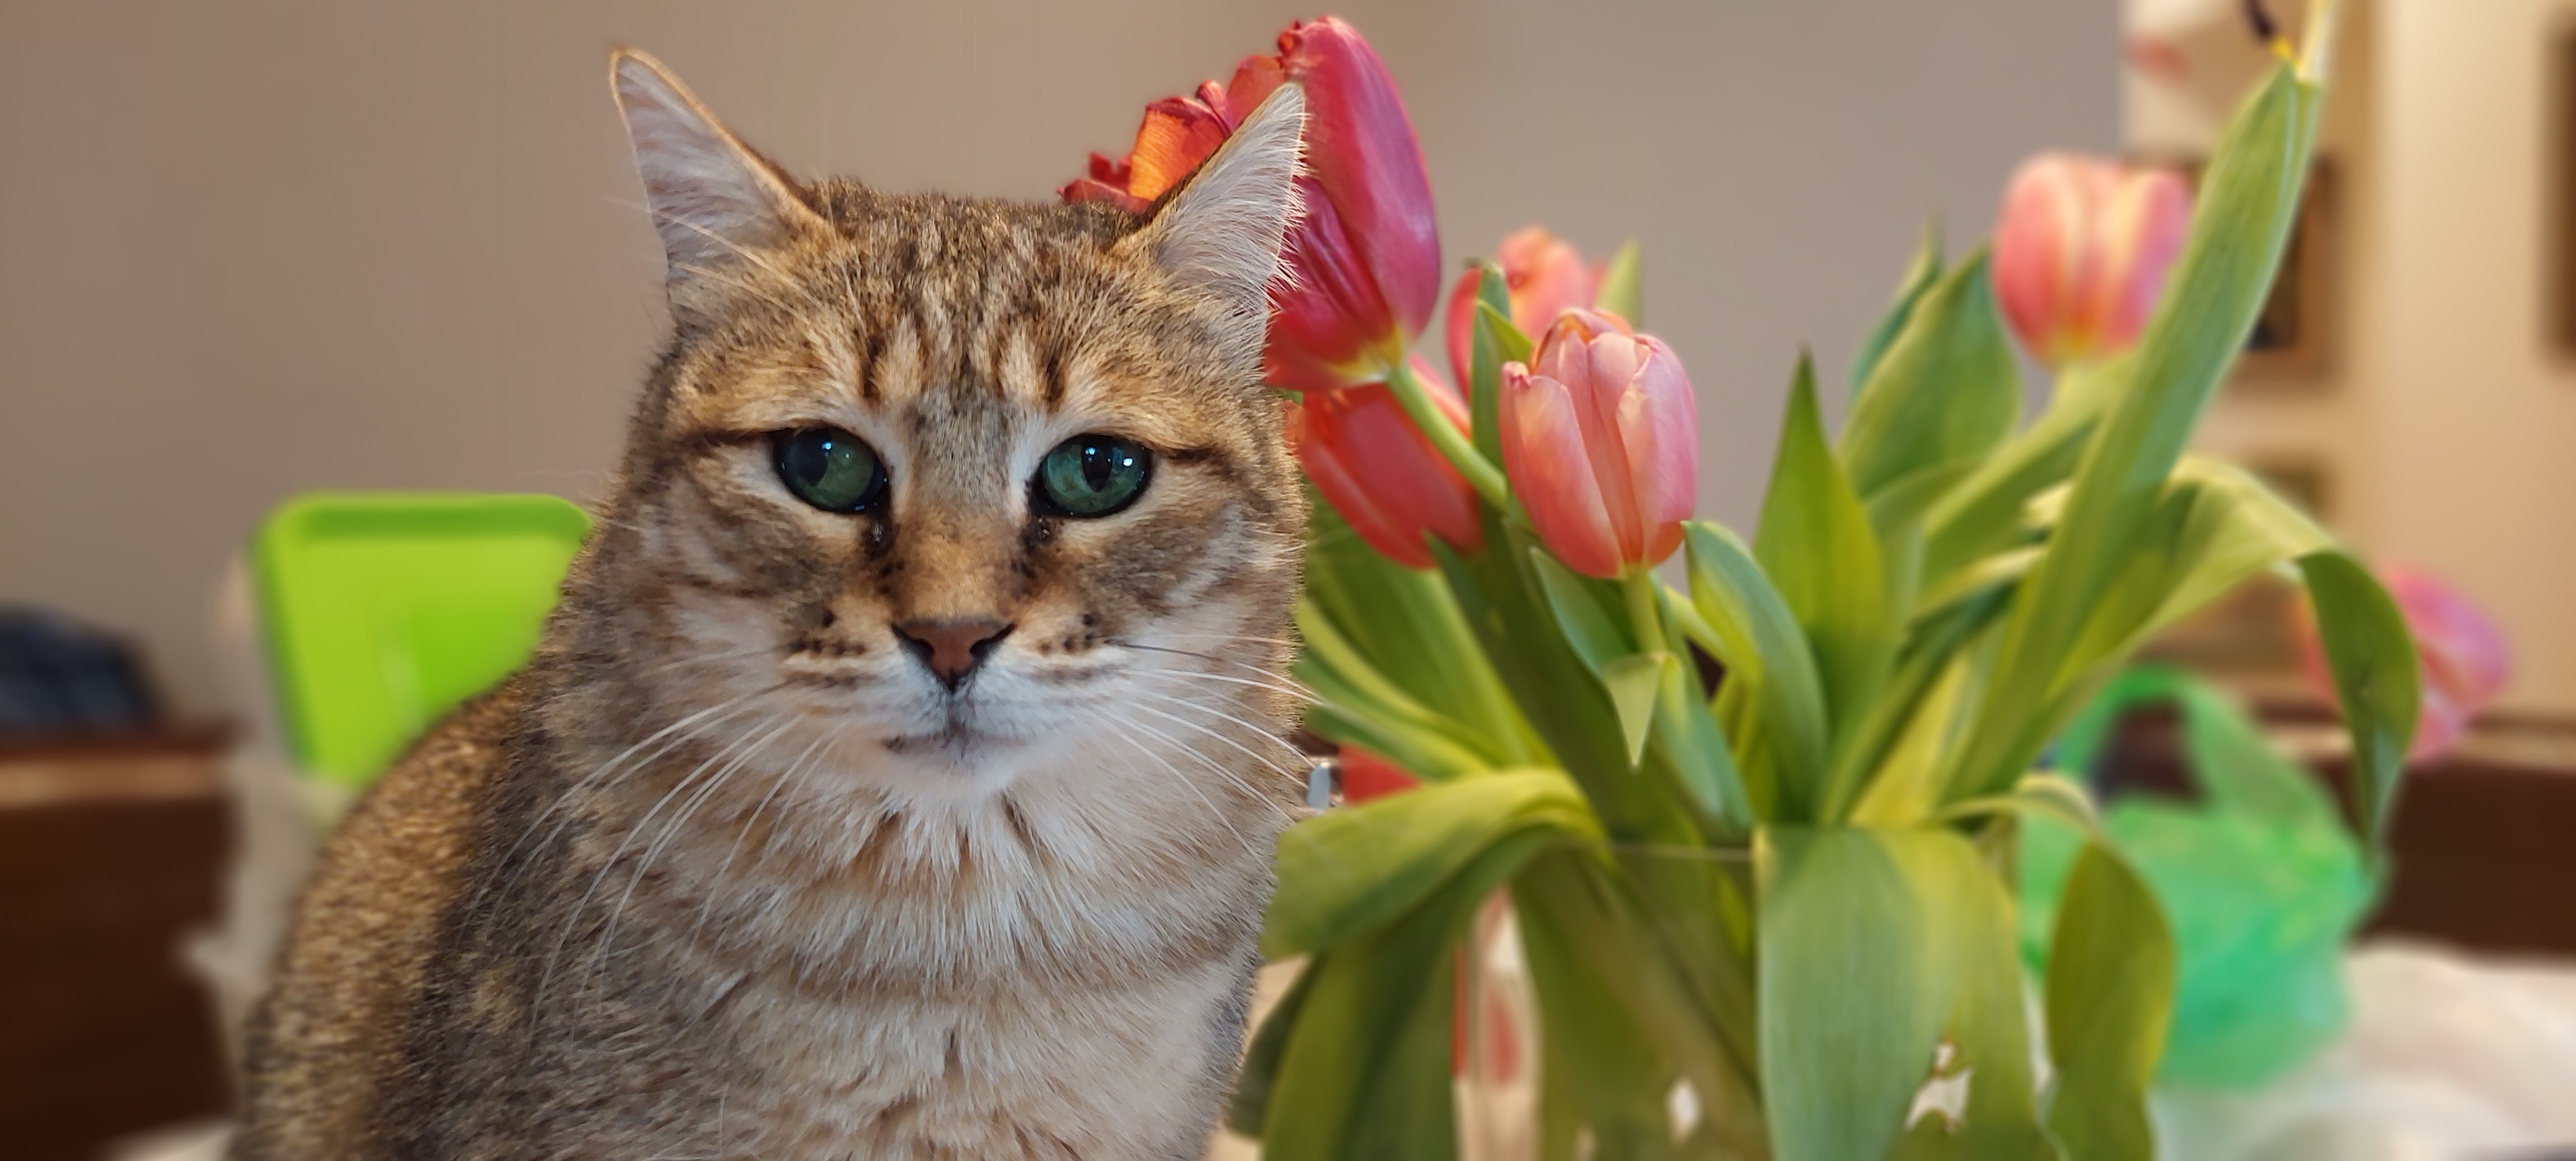

In [7]:
from google.colab import drive
from PIL import Image
drive.mount('/content/drive')
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Data/Images/Mitsi.jpg")
img

## Adjust the image to match the input format required by ResNet.

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),  # Both for height and width.
    transforms.CenterCrop(224),  # Crop it to be 224
    transforms.ToTensor(), # Convert to multi-dimentional tensor (data-structure).
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Reduce the range of values without affecting their actual ratio.
])

img = transform(img)
img.shape

torch.Size([3, 224, 224])

In [23]:
# Using CPU
# img_batch = torch.unsqueeze(img, 0)

# Using GPU
img_batch = torch.unsqueeze(img, 0).to("cuda") # Set the first dimension of the tensor to the batch size
img_batch.shape

torch.Size([1, 3, 224, 224])

# Inference

In [38]:
# Set the model to evalutaion mode (to make prediction)
model.eval()
with torch.no_grad():  # Gradient not required for inference (only for training purposes)
    outputs = model(img_batch)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

In [13]:
imagenet_classes = pd.read_csv('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt', header=None)
imagenet_classes[0][2]

'great white shark'

In [25]:
# Get model top 5 class probabilities
topk = 5
probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = imagenet_classes[0][int(classes[i])]
    print("{}% {}".format(int(probability*100), class_label))

47% Egyptian cat
30% tabby
17% tiger cat
2% lynx
0% plastic bag


## Benchmarking

The following code is copied from TensorRT and has been modified for benchmarking purposes with adjusted parameters.


In [20]:
# Copied from TensorRT
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def benchmark(model, device="cuda", input_shape=(32, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=100):
    """
     Changes to the default benchmark:
          1024 -> 32 (batch-size)
          1 -> 3 (color channel)
          10000 -> 100
          new parameter: device = 'cuda'
    """
    input_data = torch.randn(input_shape)
    input_data = input_data.to(device)

    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize() # CPU wait for GPU
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    average_batch_time = np.mean(timings)*1000
    print('Average batch time: %.2f ms'%(average_batch_time))
    return average_batch_time

In [21]:
# CPU benchmarks
cpu_average_batch_time = benchmark(model, device="cpu")

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 4101.63 ms
Iteration 20/100, ave batch time 3982.10 ms
Iteration 30/100, ave batch time 3896.95 ms
Iteration 40/100, ave batch time 3865.91 ms
Iteration 50/100, ave batch time 3840.04 ms
Iteration 60/100, ave batch time 3876.35 ms
Iteration 70/100, ave batch time 3880.64 ms
Iteration 80/100, ave batch time 3930.67 ms
Iteration 90/100, ave batch time 3967.42 ms
Iteration 100/100, ave batch time 3965.62 ms
Input shape: torch.Size([32, 3, 224, 224])
Output features size: torch.Size([32, 1000])
Average batch time: 3965.62 ms


In [26]:
# CUDA benchmarks
model = model.to("cuda")
gpu_cuda_average_batch_time = benchmark(model)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 27.90 ms
Iteration 20/100, ave batch time 27.84 ms
Iteration 30/100, ave batch time 27.83 ms
Iteration 40/100, ave batch time 27.84 ms
Iteration 50/100, ave batch time 27.84 ms
Iteration 60/100, ave batch time 27.84 ms
Iteration 70/100, ave batch time 27.85 ms
Iteration 80/100, ave batch time 27.85 ms
Iteration 90/100, ave batch time 27.85 ms
Iteration 100/100, ave batch time 27.85 ms
Input shape: torch.Size([32, 3, 224, 224])
Output features size: torch.Size([32, 1000])
Average batch time: 27.85 ms


In [27]:
# TensorRT expects a traced version of the model.
traced_model = torch.jit.trace(model, [torch.randn((32, 3, 224, 224)).to("cuda")])

In [28]:
!pip install torch-tensorrt
!pip install nvidia-pyindex
!pip install nvidia-tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8418 sha256=6b63a6dcd20b46a2c06cad09140199dd85f86fa49935997773d397f5bf04c1c3
  Stored in directory: /root/.cache/pip/wheels/2c/af/d0/7a12f82cab69f65d51107f48bcd6179e29b9a69a90546332b3
Successfully built nvidia-pyindex
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1-py2.py3-none-any.whl size=16972 sha256=072e2ba1528936f0fa4cef44212370460e34567087fe48508c711001af38a1e3
  Stored in directory: /root/.cache/pip/wheels/6d/29/56/abdffd4c604f255b5254bef3f1c598ab7811ea020540599438
Successfully built tensorrt


In [37]:
import torch_tensorrt
# Convert traced model to a torch-TensorRT model
trt_model = torch_tensorrt.compile(
    traced_model,
    inputs = [torch_tensorrt.Input((32, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions = {torch.float32}
)

In [32]:
tensor_torch_average_batch_time = benchmark(trt_model)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 19.63 ms
Iteration 20/100, ave batch time 19.64 ms
Iteration 30/100, ave batch time 19.54 ms
Iteration 40/100, ave batch time 19.52 ms
Iteration 50/100, ave batch time 19.51 ms
Iteration 60/100, ave batch time 19.49 ms
Iteration 70/100, ave batch time 19.58 ms
Iteration 80/100, ave batch time 19.57 ms
Iteration 90/100, ave batch time 19.59 ms
Iteration 100/100, ave batch time 19.59 ms
Input shape: torch.Size([32, 3, 224, 224])
Output features size: torch.Size([32, 1000])
Average batch time: 19.59 ms


In [34]:
trt_model.eval()
with torch.no_grad():
    outputs = trt_model(img_batch)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = imagenet_classes[0][int(classes[i])]
    print("{}% {}".format(int(probability*100), class_label))

47% Egyptian cat
30% tabby
17% tiger cat
2% lynx
0% plastic bag


In [35]:
# Compare run times
speedup_ratio = gpu_cuda_average_batch_time / tensor_torch_average_batch_time
speedup_ratio

1.4215702451783172

## Now my model is running on TorchTensorRT -  and it's getting closer to being around twice as fast as PyTorch with CUDA!

In [ ]:
# General information about the CUDA memory after using it
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 127991 KiB |   2765 MiB | 578808 MiB | 578683 MiB |
|       from large pool | 109440 KiB |   2747 MiB | 577703 MiB | 577596 MiB |
|       from small pool |  18551 KiB |     20 MiB |   1104 MiB |   1086 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 127991 KiB |   2765 MiB | 578808 MiB | 578683 MiB |
|       from large pool | 109440 KiB |   2747 MiB | 577703 MiB |